---

OASIS-1 es una valiosa colección de datos de resonancia magnética (RM) transversal que abarca a **416 sujetos** de entre **18 y 96 años**. Cada participante se sometió a entre tres y cuatro exploraciones de RM ponderadas en T1 durante una única sesión. Es importante destacar que todos los sujetos eran diestros, e incluían tanto a hombres como a mujeres. Un subconjunto significativo de esta cohorte, **100 sujetos mayores de 60 años**, fueron diagnosticados clínicamente con la enfermedad de Alzheimer en una fase de muy leve a moderada. Además, la recopilación incluye un conjunto de datos de fiabilidad de 20 sujetos sin demencia, a quienes se les realizaron imágenes dentro de los 90 días posteriores a su visita inicial, lo que añade una capa de robustez al estudio. 💪

El propósito central de OASIS-1 es proporcionar un conjunto de datos exhaustivo de RM transversal que cubra un amplio espectro de edades, desde adultos jóvenes y de mediana edad hasta personas mayores con y sin demencia. Estos datos son increíblemente valiosos para la investigación en neurociencia, especialmente para estudiar cómo el cerebro envejece de forma normal y cómo se ve afectado por enfermedades neurodegenerativas como el **Alzheimer**. Permiten a los investigadores analizar y comprender los cambios estructurales en el cerebro a lo largo de un amplio rango de edades y bajo diversas condiciones clínicas. 💡

---

Para analizar en profundidad estos datos de RM, una herramienta fundamental en la comunidad de la neurociencia es **FreeSurfer**. Se trata de un potente paquete de software de **código abierto** diseñado específicamente para procesar y analizar imágenes de resonancia magnética del cerebro. FreeSurfer ofrece una serie de capacidades de análisis automatizado que son esenciales para desentrañar la información contenida en conjuntos de datos como OASIS-1.

Entre sus funciones clave se incluyen:

* **Segmentación volumétrica:** Identifica y cuantifica el volumen de diferentes estructuras cerebrales como la sustancia gris, la sustancia blanca y el líquido cefalorraquídeo, así como subregiones específicas como el hipocampo o la amígdala. 🧠💧
* **Reconstrucción de la superficie cortical:** Crea modelos 3D detallados de la corteza cerebral que permiten medir métricas críticas como el grosor cortical, el área de la superficie y la curvatura del cerebro. Estas mediciones son cruciales para entender cómo evoluciona el cerebro con la edad y cómo se altera en diversas patologías neurológicas. 📈
* **Análisis estadístico:** Facilita el análisis estadístico, lo que permite a los investigadores realizar comparaciones significativas entre diferentes grupos de sujetos (por ejemplo, pacientes con Alzheimer versus controles sanos) o seguir los cambios en un mismo individuo a lo largo del tiempo. 📊

Al aplicar FreeSurfer a los escaneos de RM ponderados en T1 de OASIS-1, los investigadores pueden extraer medidas anatómicas cerebrales detalladas, como los cambios en el volumen de la materia gris en regiones específicas o el adelgazamiento de la corteza, que son indicadores vitales en el estudio de enfermedades como el Alzheimer. De hecho, la estrecha relación entre estos datos y las herramientas de análisis como FreeSurfer es tan fuerte que algunos conjuntos de datos OASIS más recientes, como OASIS-3, incluso ofrecen directamente las salidas preprocesadas con FreeSurfer para su descarga, simplificando aún más la investigación.✨

Por ese mitivo hemos decidido usar como primer acercamiento OASIS-1.

In [5]:
import nibabel as nib
import scipy.ndimage as ndi 
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd

In [48]:
crossSectional = pd.read_excel("oasis_cross-sectional.xlsx")
ND = crossSectional[crossSectional["CDR"] == 0];VM = crossSectional[crossSectional["CDR"] == 0.5];MiD = crossSectional[crossSectional["CDR"] == 1];MoD = crossSectional[crossSectional["CDR"] == 2]

In [67]:
for i in crossSectional.index:
    print("1/" + crossSectional["ID"][i] + "/mri/norm.mgz")



1/OAS1_0001_MR1/mri/norm.mgz
1/OAS1_0002_MR1/mri/norm.mgz
1/OAS1_0003_MR1/mri/norm.mgz
1/OAS1_0004_MR1/mri/norm.mgz
1/OAS1_0005_MR1/mri/norm.mgz
1/OAS1_0006_MR1/mri/norm.mgz
1/OAS1_0007_MR1/mri/norm.mgz
1/OAS1_0009_MR1/mri/norm.mgz
1/OAS1_0010_MR1/mri/norm.mgz
1/OAS1_0011_MR1/mri/norm.mgz
1/OAS1_0012_MR1/mri/norm.mgz
1/OAS1_0013_MR1/mri/norm.mgz
1/OAS1_0014_MR1/mri/norm.mgz
1/OAS1_0015_MR1/mri/norm.mgz
1/OAS1_0016_MR1/mri/norm.mgz
1/OAS1_0017_MR1/mri/norm.mgz
1/OAS1_0018_MR1/mri/norm.mgz
1/OAS1_0019_MR1/mri/norm.mgz
1/OAS1_0020_MR1/mri/norm.mgz
1/OAS1_0021_MR1/mri/norm.mgz
1/OAS1_0022_MR1/mri/norm.mgz
1/OAS1_0023_MR1/mri/norm.mgz
1/OAS1_0025_MR1/mri/norm.mgz
1/OAS1_0026_MR1/mri/norm.mgz
1/OAS1_0027_MR1/mri/norm.mgz
1/OAS1_0028_MR1/mri/norm.mgz
1/OAS1_0029_MR1/mri/norm.mgz
1/OAS1_0030_MR1/mri/norm.mgz
1/OAS1_0031_MR1/mri/norm.mgz
1/OAS1_0032_MR1/mri/norm.mgz
1/OAS1_0033_MR1/mri/norm.mgz
1/OAS1_0034_MR1/mri/norm.mgz
1/OAS1_0035_MR1/mri/norm.mgz
1/OAS1_0037_MR1/mri/norm.mgz
1/OAS1_0038_MR

In [68]:
img = nib.load("/home/nicolas/Documentos/gliara/OASIS/1/OAS1_0010_MR1/mri/norm.mgz") # norm plis
data = img.get_fdata()

In [69]:
nx, ny, nz = data.shape
print(f"Dimensiones del volumen: {nx} (X) x {ny} (Y) x {nz} (Z)")
print(f"Tipo de datos (dtype): {data.dtype}")

Dimensiones del volumen: 256 (X) x 256 (Y) x 256 (Z)
Tipo de datos (dtype): float64


# Visualizar Neuroimagen
### Funcion para visualizar nib

In [74]:
def plot_slices(data):
    plt.figure(figsize=(15, 5))

    # Vista Axial (plano XY)
    slice_z_index = nz // 2
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(data[:, :, slice_z_index].T, cmap='gray', origin='lower')
    ax1.set_title(f'Vista Axial (Z={slice_z_index})')
    ax1.axis('off')

    # Vista Coronal (plano XZ)
    slice_y_index = ny // 2
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(data[:, slice_y_index, :].T, cmap='gray', origin='lower')
    ax2.set_title(f'Vista Coronal (Y={slice_y_index})')
    ax2.axis('off')

    # Vista Sagital (plano YZ)
    slice_x_index = nx // 2
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(data[slice_x_index, :, :].T, cmap='gray', origin='lower')
    ax3.set_title(f'Vista Sagital (X={slice_x_index})')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()
    return None


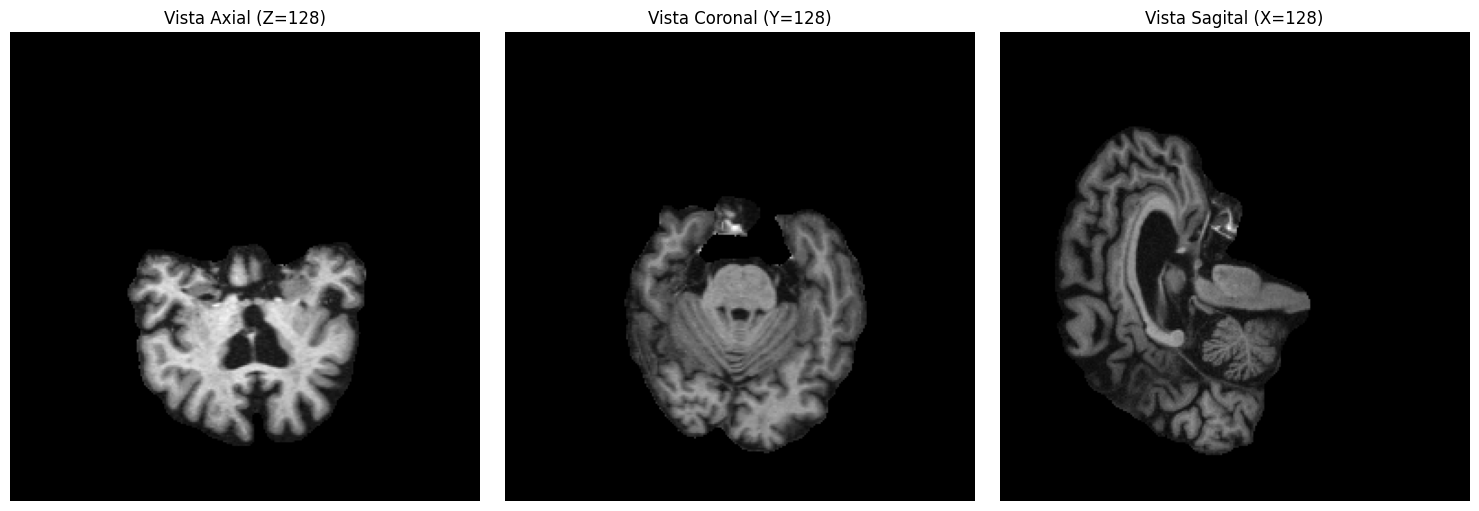

In [75]:
plot_slices(data)

# Stats

In [90]:
aseg_stats_path =  "/home/nicolas/Documentos/gliara/OASIS/1/OAS1_0002_MR1/stats/aseg.stats"

subjects_dir = "/home/nicolas/Documentos/gliara/OASIS/1/" # Reemplaza con tu ruta real
subject_id = 'OAS1_0005_MR1' # Reemplaza con el ID de un sujeto de ejemplo

# Ruta al archivo aseg.stats
aseg_stats_path = os.path.join(subjects_dir, subject_id, 'stats', 'aseg.stats')

In [91]:
aseg_stats_path

'/home/nicolas/Documentos/gliara/OASIS/1/OAS1_0005_MR1/stats/aseg.stats'

In [ ]:
try:
    with open(aseg_stats_path, 'r') as f:
        lines = f.readlines()

    data_lines = []
    header_found = False
    header_line_idx = -1
    for i, line in enumerate(lines):
        if 'StructName' in line and 'Volume_mm3' in line and not line.startswith('#'):
            header_line_idx = i
            break
            
    if header_line_idx == -1:
        print("Advertencia: No se encontró la cabecera 'StructName Volume_mm3'. Intentando lectura general.")
        data_block_lines = [line for line in lines if not line.strip().startswith('#') and line.strip()]
        df_aseg = pd.read_csv(aseg_stats_path, delim_whitespace=True, comment='#')
    else:
        df_aseg = pd.read_csv(aseg_stats_path,
                              skiprows=header_line_idx, 
                              delim_whitespace=True,     
                              comment='#')             
        if 'StructName' in df_aseg.columns:
            df_aseg = df_aseg[pd.to_numeric(df_aseg['Volume_mm3'], errors='coerce').notna()]
            summary_terms = ['BrainSeg', 'eTIV', 'Total', 'NumVert', 'CortexVol', 'SubCortSeg']
            df_aseg = df_aseg[~df_aseg['StructName'].str.contains('|'.join(summary_terms), case=False, na=False)]
            for col in ['Volume_mm3', 'SurfArea_mm2', 'ThickAvg_mm', 'ThickStd_mm', 'MinCurv', 'MaxCurv', 'GausCurv', 'FoldInd', 'CurvInd']:
                if col in df_aseg.columns:
                    df_aseg[col] = pd.to_numeric(df_aseg[col], errors='coerce')
        
    print("\nDataFrame para aseg.stats (primeras 5 filas después de limpieza):")
    print(df_aseg.head())
    print("\nColumnas del DataFrame:")
    print(df_aseg.columns)

except FileNotFoundError:
    print(f"Error: El archivo no fue encontrado en {aseg_stats_path}. Verifica la ruta.")
except Exception as e:
    print(f"Ocurrió un error al cargar el archivo aseg.stats: {e}")
    print("Revisa el archivo manualmente para entender su formato.")

print("\n--- Cargando un archivo aparc.stats (ejemplo) ---")
aparc_stats_path = os.path.join(subjects_dir, subject_id, 'stats', 'lh.aparc.stats')

try:    
    df_aparc = pd.read_csv(aparc_stats_path,
                           delim_whitespace=True,
                           comment='#',
                           header=None,
                           engine='python')
    with open(aparc_stats_path, 'r') as f:
        header_line = None
        for line in f:
            if line.startswith('# ColHeaders'):
                # Extraer los nombres de las columnas de la línea de comentario
                header_line = line.strip('# ColHeaders').strip().split()
                break
        if header_line:
            df_aparc_raw = pd.read_csv(aparc_stats_path, delim_whitespace=True, comment='#', header=None, engine='python')
            
            if not df_aparc_raw.empty and str(df_aparc_raw.iloc[-1, 0]).strip().upper() == 'TOTAL':
                df_aparc_raw = df_aparc_raw.iloc[:-1]
            if len(header_line) == df_aparc_raw.shape[1]:
                df_aparc_raw.columns = header_line
            else:
                print("Advertencia: El número de columnas no coincide con la cabecera extraída. Asignando cabeceras genéricas.")
                df_aparc_raw.columns = [f'Col{i}' for i in range(df_aparc_raw.shape[1])]
                
            df_aparc = df_aparc_raw
        else:
            print("Advertencia: No se encontró la línea '# ColHeaders' en aparc.stats. Intentando lectura genérica.")
            df_aparc = pd.read_csv(aparc_stats_path, delim_whitespace=True, comment='#', engine='python') # Sin header específico
            
    print("\nDataFrame para lh.aparc.stats (primeras 5 filas después de limpieza):")
    print(df_aparc.head())
    print("\nColumnas del DataFrame:")
    print(df_aparc.columns)

except FileNotFoundError:
    print(f"Error: El archivo no fue encontrado en {aparc_stats_path}. Verifica la ruta.")
except Exception as e:
    print(f"Ocurrió un error al cargar el archivo aparc.stats: {e}")

Advertencia: No se encontró la cabecera 'StructName Volume_mm3'. Intentando lectura general.

DataFrame para aseg.stats (primeras 5 filas después de limpieza):
   1  2  248654  248654.0    Left-Cerebral-White-Matter  107.6196   9.7370  \
0  2  3  309574  309574.0          Left-Cerebral-Cortex   67.8282  10.3803   
1  3  4    4966    4966.0        Left-Lateral-Ventricle   34.9422  14.0418   
2  4  5     647     647.0             Left-Inf-Lat-Vent   50.5707  15.6885   
3  5  7   13875   13875.0  Left-Cerebellum-White-Matter   92.1639   6.7670   
4  6  8   58117   58117.0        Left-Cerebellum-Cortex   62.9542   8.8385   

   52.0000  137.0000  85.0000  
0     28.0     130.0    102.0  
1     11.0      79.0     68.0  
2     15.0      92.0     77.0  
3     46.0     112.0     66.0  
4     21.0     108.0     87.0  

Columnas del DataFrame:
Index(['1', '2', '248654', '248654.0', 'Left-Cerebral-White-Matter',
       '107.6196', '9.7370', '52.0000', '137.0000', '85.0000'],
      dtype='object')

/tmp/ipykernel_17240/4046628048.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_aseg = pd.read_csv(aseg_stats_path, delim_whitespace=True, comment='#')
/tmp/ipykernel_17240/4046628048.py:45: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_aparc = pd.read_csv(aparc_stats_path,



DataFrame para lh.aparc.stats (primeras 5 filas después de limpieza):
                StructName  NumVert  SurfArea  GrayVol  ThickAvg  ThickStd  \
0                  unknown    14500      9011    14659     1.431     1.457   
1                 bankssts     1960      1291     2446     2.017     0.486   
2  caudalanteriorcingulate      654       476     1189     2.215     0.591   
3      caudalmiddlefrontal     4418      3129     9307     2.571     0.674   
4           corpuscallosum      770       478      906     2.224     0.996   

   MeanCurv  GausCurv  FoldInd  CurvInd  
0     0.094     0.046  272.301   32.864  
1     0.099     0.016   14.147    1.396  
2     0.105     0.015    4.411    0.472  
3     0.135     0.030   55.843    5.515  
4     0.145     0.025   16.712    0.605  

Columnas del DataFrame:
Index(['StructName', 'NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd',
       'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd'],
      dtype='object')


/tmp/ipykernel_17240/4046628048.py:60: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_aparc_raw = pd.read_csv(aparc_stats_path, delim_whitespace=True, comment='#', header=None, engine='python')


In [94]:
df_aparc
df_aseg

,1,2,248654,248654.0,Left-Cerebral-White-Matter,107.6196,9.7370,52.0000,137.0000,85.0000
0,2,3,309574,309574.0,Left-Cerebral-Cortex,67.8282,10.3803,28.0,130.0,102.0
1,3,4,4966,4966.0,Left-Lateral-Ventricle,34.9422,14.0418,11.0,79.0,68.0
2,4,5,647,647.0,Left-Inf-Lat-Vent,50.5707,15.6885,15.0,92.0,77.0
3,5,7,13875,13875.0,Left-Cerebellum-White-Matter,92.1639,6.7670,46.0,112.0,66.0
4,6,8,58117,58117.0,Left-Cerebellum-Cortex,62.9542,8.8385,21.0,108.0,87.0
5,7,10,7430,7430.0,Left-Thalamus-Proper,90.9822,10.2751,54.0,129.0,75.0
6,8,11,3417,3417.0,Left-Caudate,77.8604,9.8482,48.0,103.0,55.0
7,9,12,7627,7627.0,Left-Putamen,86.1209,8.1130,60.0,110.0,50.0
8,10,13,1960,1960.0,Left-Pallidum,102.6204,5.7924,80.0,121.0,41.0
9,11,14,1154,1154.0,3rd-Ventricle,41.5478,13.1560,12.0,71.0,59.0


# Aumentacion de datos

## Aumentacion de Neuroimagen

In [24]:
def random_rotation_3d(image, max_angle=10):
    angles = [random.uniform(-max_angle, max_angle) for _ in range(3)] # X, Y, Z
    rotated_image = image
    for axis, angle in enumerate(angles):
        rotated_image = ndi.rotate(rotated_image, angle, axes=(axis, (axis + 1) % 3),
                                   reshape=False, order=1, mode='nearest')
    return rotated_image

def random_shift_3d(image, max_shift_pixels=5):
    shift_x = random.randint(-max_shift_pixels, max_shift_pixels)
    shift_y = random.randint(-max_shift_pixels, max_shift_pixels)
    shift_z = random.randint(-max_shift_pixels, max_shift_pixels)
    shifted_image = ndi.shift(image, (shift_x, shift_y, shift_z), order=1, mode='nearest')
    return shifted_image

def random_intensity_scale(image, scale_factor_range=(0.8, 1.2), add_offset_range=(-0.1, 0.1)):
    scale_factor = random.uniform(*scale_factor_range)
    add_offset = random.uniform(*add_offset_range)
    augmented_image = image * scale_factor + add_offset
    return augmented_image

def add_gaussian_noise(image, noise_std_dev=0.03):
    noise = np.random.normal(0, noise_std_dev, image.shape)
    augmented_image = image + noise
    return augmented_image

def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    if max_val - min_val > 0:
        return (image - min_val) / (max_val - min_val)
    return image 

def apply_augmentations(image):
    image = random_rotation_3d(image, max_angle=10)
    image = random_shift_3d(image, max_shift_pixels=5)
    image = random_intensity_scale(image, scale_factor_range=(0.8, 1.2), add_offset_range=(-0.1, 0.1))
    image = add_gaussian_noise(image, noise_std_dev=0.05)
    return normalize_image(image)

## Aumentacion de stats